In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from textblob import TextBlob
from textblob import Word
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
import smart_open
from sklearn.feature_extraction.text import CountVectorizer
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv("consumer_complaints.csv")
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [5]:
req_cols=['product','consumer_complaint_narrative']
df=df[req_cols]
df=df[pd.notnull(df[req_cols[1]])]
df['labels']=df['product'].factorize()[0]
X=df.to_numpy()
temp=df[['product','labels']].drop_duplicates().sort_values('labels')
pr_to_lab=dict(temp.values)
lab_to_pr=dict(temp[['labels','product']].values)
df.head()

,product,consumer_complaint_narrative,labels
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


Debt collection 17552.0
Consumer Loan 3678.0
Mortgage 14919.0
Credit card 7929.0
Credit reporting 12526.0
Student loan 2128.0
Bank account or service 5711.0
Payday loan 726.0
Money transfers 666.0
Other financial service 110.0
Prepaid card 861.0


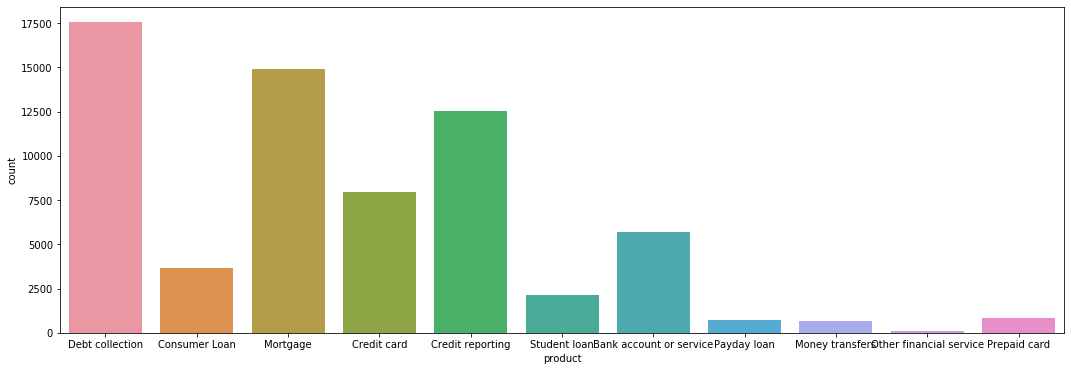

In [6]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(x='product',data=df)
count=np.zeros(11)
for i in range(X.shape[0]):
    count[X[i][2]]+=1;
for i in range(11):
    print(lab_to_pr[i],count[i])

In [7]:
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].str.lower()
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].str.replace(r'[^\w\s]',"")

dico = {}
# dico1 = open('doc1.txt', 'rb')
# for word in dico1:
#     word = word.decode('utf8')
#     word = word.split()
#     dico[word[1]] = word[3]
# dico1.close()
dico2=open('doc2.txt', 'rb')
for word in dico2:
    word=word.decode('utf8')
    word=word.split()
    dico[word[0]]=word[1]
dico2.close()
dico3=open('doc3.txt', 'rb')
for word in dico3:
    word=word.decode('utf8')
    word=word.split()
    dico[word[0]]=word[1]
dico3.close()

def txt_std(words):
    list_words=words.split()
    for i in range(len(list_words)):
        if list_words[i] in dico.keys():
            list_words[i]=dico[list_words[i]]
    return ' '.join(list_words)

df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].apply(txt_std)
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].str.replace(r"xx+\s","")
df.head()

,product,consumer_complaint_narrative,labels
190126,Debt collection,has claimed i owe them 2700 for years despite ...,0
190135,Consumer Loan,due to inconsistencies in the amount owed that...,1
190155,Mortgage,in my wages that i earned at my job decreased ...,2
190207,Mortgage,i have an open and current mortgage with chase...,2
190208,Mortgage,was submitted at the time i submitted this com...,2


In [8]:
stop=stopwords.words('english')
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].apply(lambda x: BeautifulSoup(x,'lxml').get_text().strip())
df.head()

,product,consumer_complaint_narrative,labels
190126,Debt collection,claimed owe 2700 years despite proof payment s...,0
190135,Consumer Loan,due inconsistencies amount owed told bank amou...,1
190155,Mortgage,wages earned job decreased almost half knew tr...,2
190207,Mortgage,open current mortgage chase bank chase reporti...,2
190208,Mortgage,submitted time submitted complaint dealt rushm...,2


In [9]:
#df['consumer_complaint_narrative'] =df['consumer_complaint_narrative'].apply(lambda x: str(TextBlob(x).correct()))
df['consumer_complaint_narrative']=df['consumer_complaint_narrative'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))
df.head()

,product,consumer_complaint_narrative,labels
190126,Debt collection,claimed owe 2700 year despite proof payment se...,0
190135,Consumer Loan,due inconsistency amount owed told bank amount...,1
190155,Mortgage,wage earned job decreased almost half knew tro...,2
190207,Mortgage,open current mortgage chase bank chase reporti...,2
190208,Mortgage,submitted time submitted complaint dealt rushm...,2


Debt collection


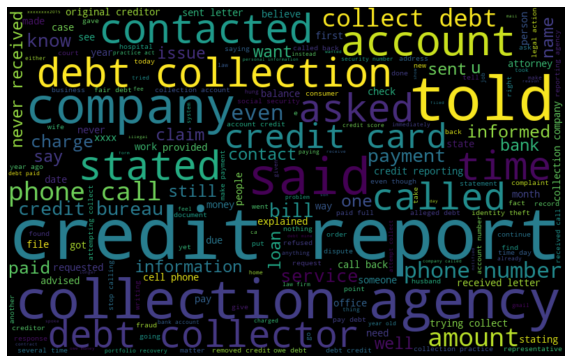

Consumer Loan


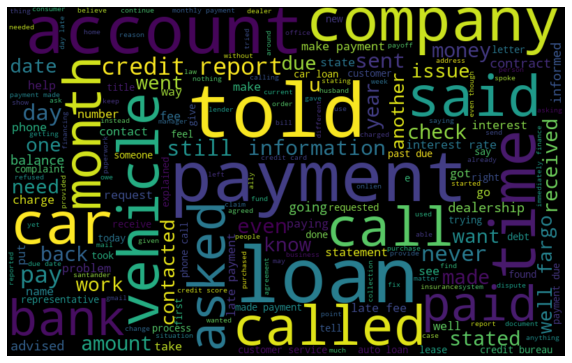

Mortgage


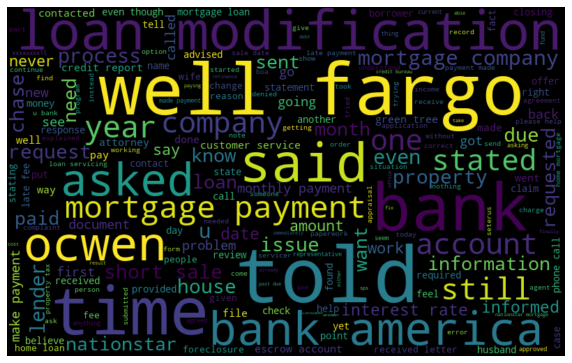

Credit card


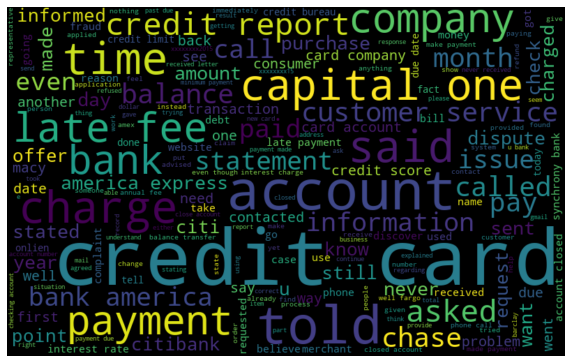

Credit reporting


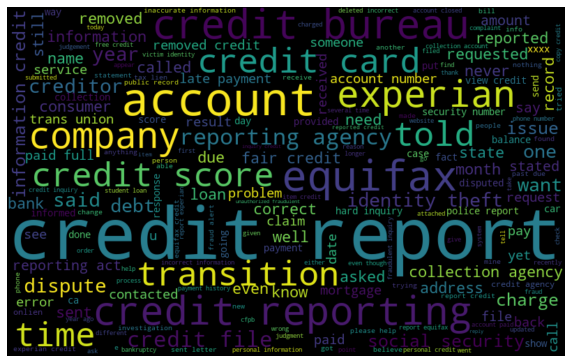

Student loan


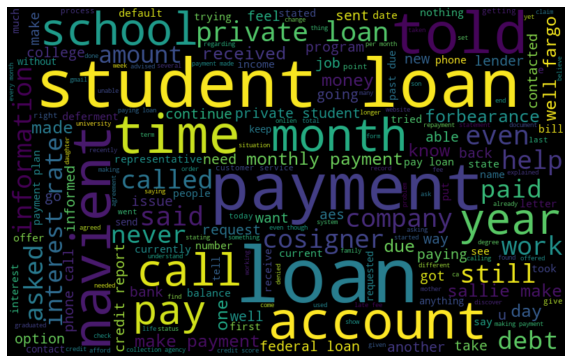

Bank account or service


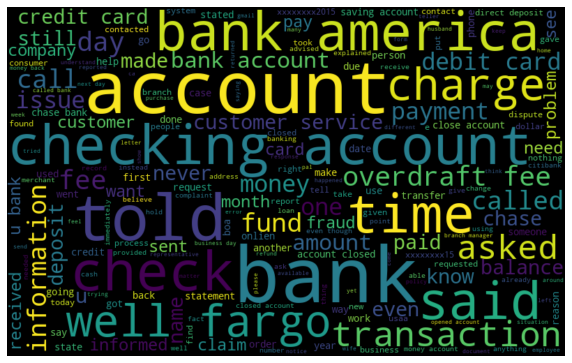

Payday loan


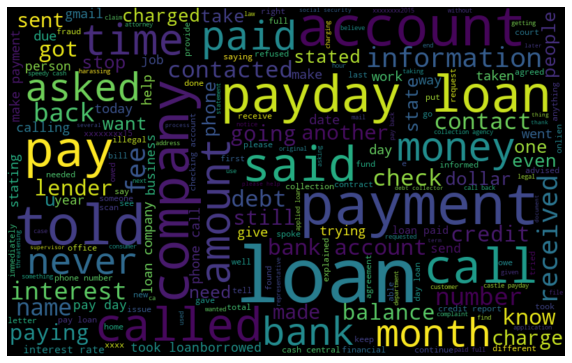

Money transfers


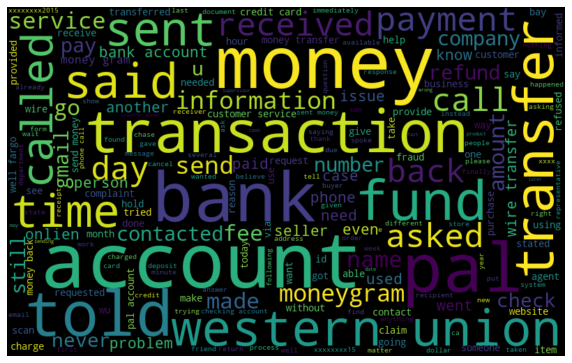

Other financial service


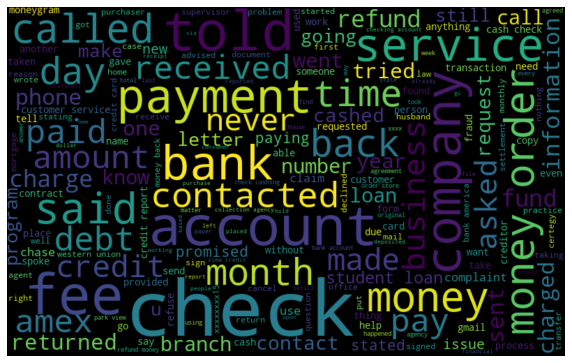

Prepaid card


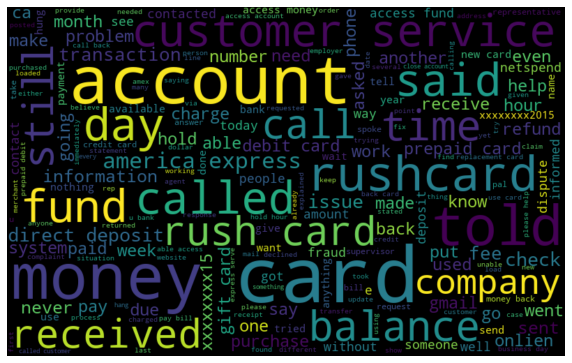

In [10]:
for product_name in df['product'].unique():
    print(product_name)
    all_words = ' '.join([text for text in df.loc[df['product'].str.contains(product_name),'consumer_complaint_narrative']])
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [ ]:
class FeatureVectorization:
    def __init__(self):
        self.df1=df
        self.vec=TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
        self.model=gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=1, epochs=30)
        vectorizer=CountVectorizer()
        self.word2vec=Word2Vec(['punit'],size=40,min_count=1)
    def tf_idf_init(self):
        self.vec.fit(self.df1['consumer_complaint_narrative'])
    def tf_idf(self,x):
        x=self.vec.transform(x)
        return x
    def build_tag(self,data,data1):
        train_tagged=[]
        for i in range(data.shape[0]):
            train_tagged.append(TaggedDocument(words=nltk.word_tokenize(data.to_numpy()[i]),tags=[data1.to_numpy()[i]]))
        return train_tagged
    def doc2vec_train(self,tagged_data):
        self.model=gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
        self.model.build_vocab(train_tagged)
        self.model.train(train_tagged, total_examples=self.model.corpus_count, epochs=self.model.epochs)
    def doc2vec(self,data):
        lis=[]
        for i in data:
            lis.append(self.model.infer_vector(i.words))
        return np.asarray(lis,dtype=np.float32)
    def word2vec_train(self,data):
        all_words=[]   
        for i in range(data.shape[0]):
            all_words.append(nltk.word_tokenize(data.to_list()[i]))
        self.word2vec=Word2Vec(all_words,size=40,min_count=1)
    def Word2vec(self,data):
        lis=[]
        for i in range(data.shape[0]):
            res=nltk.word_tokenize(data.to_list()[i])
            m=np.zeros(40)
            for j in range(len(res)):
                m=m+self.word2vec.wv[res[j]]
            lis.append(m)
        return np.asarray(lis,dtype=np.float32)
    def bow_train(self):
        self.vectorizer=CountVectorizer()
        self.vectorizer.fit(df['consumer_complaint_narrative'])
    def bow(self,data):
        vector=self.vectorizer.transform(data)
        print(vector.shape)
        vector=vector.toarray()
        return vector
    def bert(self,data):
        tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased')
        text=data.to_list()
        sent_id=tokenizer.batch_encode_plus(text,padding=True,truncation=True,return_token_type_ids=False)
        return np.asarray(sent_id.input_ids,dtype=np.float32)

In [ ]:
class models:
    def logistic(self,x_train,y_train,x_test,y_test):
        model=linear_model.LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(x_train,y_train)
        y_pred=model.predict(x_test)
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(y_test,y_pred)
        fig, ax=plt.subplots(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df['product'].unique(),yticklabels=df['product'].unique())
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        from sklearn.metrics import classification_report
        print(classification_report(y_test,y_pred,target_names=df['product'].unique()))
        acc=metrics.accuracy_score(y_test,y_pred)
        f1=metrics.f1_score(y_test,y_pred,average='weighted')
        y_pred1=model.predict(x_train)
        acc1=metrics.accuracy_score(y_train,y_pred1)
        f11=metrics.f1_score(y_train,y_pred1,average='weighted')
        return (acc,f1,acc1,f11)
        #print(metrics.classification_report(y_test,model.predict(x_test),target_names=df['product'].unique()))
    def svm(self,x_train,y_train,x_test,y_test):
        model=LinearSVC(dual=False).fit(x_train,y_train)
        y_pred=model.predict(x_test)
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(y_test,y_pred)
        fig, ax=plt.subplots(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df['product'].unique(),yticklabels=df['product'].unique())
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        acc=metrics.accuracy_score(y_test,y_pred)
        f1=metrics.f1_score(y_test,y_pred,average='weighted')
        y_pred1=model.predict(x_train)
        acc1=metrics.accuracy_score(y_train,y_pred1)
        f11=metrics.f1_score(y_train,y_pred1,average='weighted')
        return (acc,f1,acc1,f11)
    def xgboost(self,x_train,y_train,x_test,y_test):
        model=XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, eta=0.3, silent=1, subsample=0.8)
        model.fit(x_train,y_train)
        y_pred=model.predict(x_test)
        acc=metrics.accuracy_score(y_test,y_pred)
        f1=metrics.f1_score(y_test,y_pred,average='weighted')
        y_pred1=model.predict(x_train)
        acc1=metrics.accuracy_score(y_train,y_pred1)
        f11=metrics.f1_score(y_train,y_pred1,average='weighted')
        return (acc,f1,acc1,f11)
        return acc
    def random_forest(self,x_train,y_train,x_test,y_test):
       # model=RandomForestClassifier()
     #   dic={0:1,1:2,2:1,3:1,4:1,5:2,6:1,7:4,8:4,9:5,10:4}
        model=RandomForestClassifier(n_estimators=100,criterion='entropy')
        model.fit(x_train, y_train)
        y_pred=model.predict(x_test)
        acc=metrics.accuracy_score(y_test,y_pred)
        f1=metrics.f1_score(y_test,y_pred,average='weighted')
        y_pred1=model.predict(x_train)
        acc1=metrics.accuracy_score(y_train,y_pred1)
        f11=metrics.f1_score(y_train,y_pred1,average='weighted')
        return (acc,f1,acc1,f11)
        return acc
    def neural_net(self,x_train,y_train,x_test,y_test):
        model=MLPClassifier(hidden_layer_sizes=(100,)).fit(x_train, y_train)
        y_pred=model.predict(x_test)
#         loss_values = model.loss_curve_
#         plt.plot(loss_values)
#         plt.show()
        acc=metrics.accuracy_score(y_test,y_pred)
        f1=metrics.f1_score(y_test,y_pred,average='weighted')
        y_pred1=model.predict(x_train)
#         loss_values = model.loss_curve_
#         plt.plot(loss_values)
#         plt.show()
        acc1=metrics.accuracy_score(y_train,y_pred1)
        f11=metrics.f1_score(y_train,y_pred1,average='weighted')
        return (acc,f1,acc1,f11)
        return acc

In [ ]:
model=models()

In [ ]:
fv=FeatureVectorization()
fv.tf_idf_init()
su=0
x_train, x_test, y_train, y_test = train_test_split(df['consumer_complaint_narrative'],df['labels'],stratify=df['labels'], 
                                                test_size=0.25)
count=np.zeros(11)
for i in range(y_train.shape[0]):
    count[y_train.to_numpy()[i]]+=1;
for i in range(11):
    print(lab_to_pr[i],count[i])

In [ ]:
x_train=fv.tf_idf(x_train)
x_test=fv.tf_idf(x_test)

# train_tagged=fv.build_tag(x_train,y_train)
# test_tagged=fv.build_tag(x_test,y_test)
# fv.doc2vec_train(train_tagged)
# x_train=fv.doc2vec(train_tagged)
# x_test=fv.doc2vec(test_tagged)

# fv.word2vec_train(df['consumer_complaint_narrative'])
# x_train=fv.Word2vec(x_train)
# x_test=fv.Word2vec(x_test)

#     fv.bow_train()
#     x_train=fv.bow(x_train)
#     x_test=fv.bow(x_test)

# x_train=fv.bert(x_train)
# scaler=preprocessing.MinMaxScaler().fit(x_train)
# x_train=scaler.transform(x_train)
# x_test=scaler.transform(fv.bert(x_test))

# dic={0:13164,1:5000,2:12000,3:6000,4:10000,5:5000,6:5000,7:5000,8:5000,9:5000,10:5000}
# oversample=SMOTE(sampling_strategy=dic)
# x_o,y_o=oversample.fit_resample(x_train,y_train)

dic={0:5000,1:2758,2:5000,3:5000,4:5000,5:1596,6:3000,7:544,8:500,9:83,10:646}
undersample=RandomUnderSampler(sampling_strategy=dic)
x_o,y_o=undersample.fit_resample(x_train,y_train)

dic={0:5000,1:2758,2:5000,3:5000,4:5000,5:1596,6:3000,7:1000,8:1000,9:1000,10:1000}
oversample=RandomOverSampler(sampling_strategy=dic)
x_o,y_o=oversample.fit_resample(x_o,y_o)

In [ ]:
print(x_o.shape)
g=model.logistic(x_o,y_o,x_test,y_test)
print(g)